# Multi-ConDoS ⚡ PyTorch Lightning ⚡

John Mark Alexis Marcelo - 1850518 

My notebook aims to implement Multi-ConDos in PyTorch Lightning ⚡, a novel approach for multimodal contrastive self-supervised medical image segmentation designed to address domain shift and multimodality challenges. It employs a novel strategy that combines CycleGAN and Pix2Pix to facilitate domain translation, essential for managing multimodal data. Additionally, it introduces domain sharing layers to capture both domain-specific and shared information across modalities.

* Original [paper](https://ieeexplore.ieee.org/document/10167829) for Multi-ConDos.
* Original [paper](https://arxiv.org/abs/1703.10593) for CycleGAN.




---

For Training I'm using Macos, so skip this part if you are not using Macos. I need for multiprocessing.

In [1]:
import multiprocessing
multiprocessing.set_start_method('fork') 

Importing all we need.

In [3]:
import glob
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as L
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from pytorch_lightning.utilities import CombinedLoader
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision.utils import make_grid, save_image

_ = L.seed_everything(0, workers=False)


Seed set to 0


---

# 1. Data Augmentation and Data Modules

- ALL BLACK IMAGES WHERE HANDLED REMOVED

Augmenting the images.

In [4]:
class Augmentation(object):
    def __init__(self, load_dim=286, target_dim=256):
        self.transform_train = T.Compose([
            T.Resize((load_dim, load_dim), antialias=True),
            T.RandomCrop((target_dim, target_dim)),
            T.RandomHorizontalFlip(p=0.5),
        ])
        self.transform = T.Compose([
            T.Resize((target_dim, target_dim), antialias=True),
        ])

    def __call__(self, img, stage):
        if stage == "fit":
            img = self.transform_train(img)
        else:
            img = self.transform(img)
        return img * 2 - 1

MulticonDataset

In [5]:
class MulticonDataset(Dataset):
    def __init__(self, filenames, transform, stage):
        self.filenames = filenames
        self.transform = transform
        self.stage = stage

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = self.filenames[idx]
        img = read_image(img_name) / 255.0
        return self.transform(img, stage=self.stage)

Datamodule Configuration

In [6]:
DATA_CONFIG = {
    #DIRECTORIES
    "t1ce_dir": os.path.join("/Users/sanjohngiangino/Desktop/MultiConDos-main/DATA/t1ce_jpg", "*.jpg"),
    "t2_dir": os.path.join("/Users/sanjohngiangino/Desktop/MultiConDos-main/DATA/t2_jpg", "*.jpg"),
    "loader_config": {
    },
    #FOR VISUAL 
    "sample_size": 8,
    "batch_size": 8,
}

Lightning DataModule

In [7]:
class MulticonDatamodule(L.LightningDataModule):
    def __init__(
        self,
        t1ce_dir,
        t2_dir,
        loader_config,
        sample_size,
        batch_size,
    ):
        super().__init__()
        self.loader_config = loader_config
        self.sample_size = sample_size
        self.batch_size = batch_size

        # store file paths
        self.t1ce_filenames = sorted(glob.glob(t1ce_dir))
        self.t2_filenames = sorted(glob.glob(t2_dir))

        # define transformations for image augmentation
        self.transform = Augmentation()

    def setup(self, stage):
        if stage == "fit":
            self.train_t1ce = MulticonDataset(self.t1ce_filenames, self.transform, stage)
            self.train_t2 = MulticonDataset(self.t2_filenames, self.transform, stage)

        if stage in ["fit", "test", "predict"]:
            # to be used for test and prediction datasets as well
            self.valid_t2 = MulticonDataset(self.t2_filenames, self.transform, None)

    def train_dataloader(self):
        loader_config = {
            "shuffle": True,
            "drop_last": True,
            "batch_size": self.batch_size,
            **self.loader_config,
        }
        loader_t1ce = DataLoader(self.train_t1ce, **loader_config)
        loader_t2 = DataLoader(self.train_t2, **loader_config)
        loaders = {"t1ce": loader_t1ce, "t2": loader_t2}
        return CombinedLoader(loaders, mode="max_size_cycle")

    def val_dataloader(self):
        return DataLoader(
            self.valid_t2,
            batch_size=self.sample_size,
            **self.loader_config,
        )

    def test_dataloader(self):
        return self.val_dataloader()

    def predict_dataloader(self):
        return DataLoader(
            self.valid_t2,
            batch_size=self.batch_size,
            **self.loader_config,
        )

In [8]:
def visualize_result(img_tensor, nrow, title=""):
    img_tensor = img_tensor.detach().cpu() * 0.5 + 0.5
    img_grid = make_grid(img_tensor, nrow=nrow).permute(1, 2, 0)
    plt.figure(figsize=(18, 18))
    plt.imshow(img_grid)
    plt.axis("off")
    plt.title(title)
    plt.show()

Checking the datamodule defined is working for training and for validation

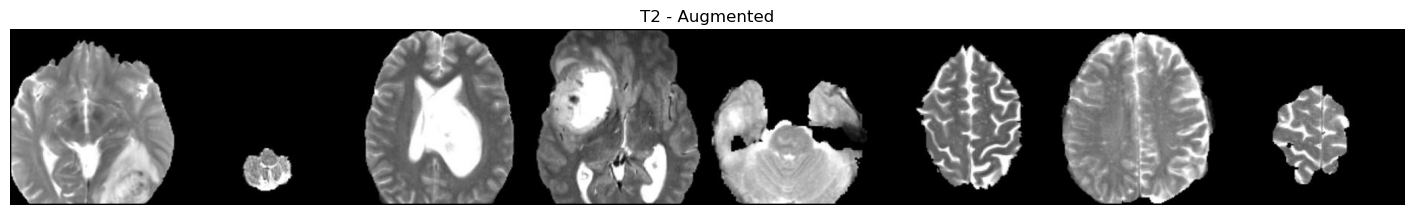

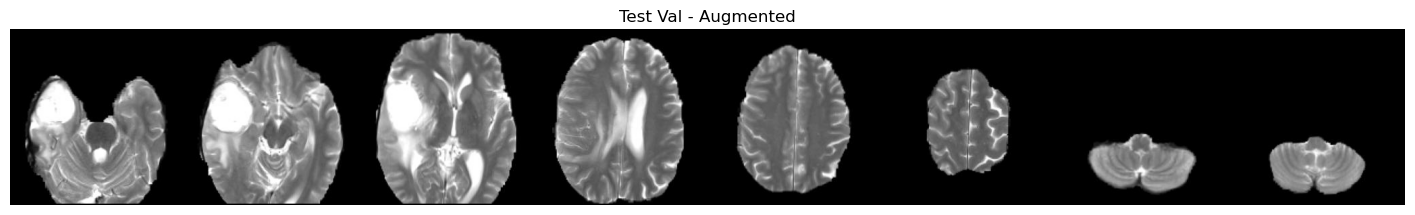

In [10]:
data_model_sample = MulticonDatamodule(batch_size=8, **{k: v for k, v in DATA_CONFIG.items() if k != "batch_size"})
data_model_sample.setup("fit")

train_loader = data_model_sample.train_dataloader()
imgs = next(iter(train_loader))

visualize_result(imgs[0]["t1ce"], nrow=8, title="T1CE - Augmented")
visualize_result(imgs[0]["t2"], nrow=8, title="T2 - Augmented")

val_loader = data_model_sample.val_dataloader()
imgs = next(iter(val_loader))

visualize_result(imgs, nrow=8, title="Test Val - Augmented")

---

# 2. MultiConDos Architecture

###  Domain-Sharing Generative Adversarial Networks (DSGAN)

The paper introduces DSGAN. They are used to conduct multimodal contrastive self-supervised pre-training using a large number of unlabeled multimodal medical images.

<img src="https://raw.githubusercontent.com/sanjohngiangino/MultiConDos/main/architecture.png" width="1000"/>

Downsampling blocks

In [11]:
class Down(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=4,
        stride=2,
        padding=1,
        norm=True,
        lrelu=True,
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,
                      kernel_size=kernel_size, stride=stride, padding=padding, bias=not norm),
        )
        if norm:
            self.block.append(nn.InstanceNorm2d(out_channels, affine=True))
        if lrelu is not None:
            self.block.append(nn.LeakyReLU(0.2, True) if lrelu else nn.ReLU(True))

    def forward(self, x):
        return self.block(x)

Upsampling blocks.

In [12]:
class Up(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=4,
        stride=2,
        padding=1,
        output_padding=0,
        dropout=False,
    ):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels,
                               kernel_size=kernel_size, stride=stride,
                               padding=padding, output_padding=output_padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True),
        )
        if dropout:
            self.block.append(nn.Dropout(0.5))
        self.block.append(nn.ReLU(True))

    def forward(self, x):
        return self.block(x)

First DSGAN that Shares Some Layer (Encoder(a) - Shared Layer - Decoder(a))

In [13]:
class DSGANsecond(nn.Module):
    def __init__(self, hid_channels, in_channels, out_channels, share):
        super().__init__()
        self.downsampling_path = nn.Sequential(
            Down(in_channels, hid_channels, norm=False), 
            Down(hid_channels, hid_channels*2), 
            Down(hid_channels*2, hid_channels*4),
            Down(hid_channels*4, hid_channels*8),
            Down(hid_channels*8, hid_channels*8),
            Down(hid_channels*8, hid_channels*8), 
        )
        self.upsampling_path = nn.Sequential(
            Up(hid_channels*16, hid_channels*8, dropout=True), 
            Up(hid_channels*16, hid_channels*8), 
            Up(hid_channels*16, hid_channels*4), 
            Up(hid_channels*8, hid_channels*2),
            Up(hid_channels*4, hid_channels), 
        )
        self.feature_block = nn.Sequential(
            nn.ConvTranspose2d(hid_channels*2, out_channels,
                               kernel_size=4, stride=2, padding=1), # 3x256x256
            nn.Tanh(),
        )
        self.share = share

    def forward(self, x):
        skips = []
        for down in self.downsampling_path:
            x = down(x)
            skips.append(x)
        skips = reversed(skips[:-1])
        x = self.share(x)
        for up, skip in zip(self.upsampling_path, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)
        return self.feature_block(x)


Second DSGAN that Shares Some Layer (Encoder(b) - Shared Layer - Decoder(b))

In [14]:
class DSGANfirst(nn.Module):
    def __init__(self, hid_channels, in_channels, out_channels,share):
        super().__init__()
        self.downsampling_path = nn.Sequential(
            Down(in_channels, hid_channels, norm=False), 
            Down(hid_channels, hid_channels*2), 
            Down(hid_channels*2, hid_channels*4), 
            Down(hid_channels*4, hid_channels*8),
            Down(hid_channels*8, hid_channels*8),
            Down(hid_channels*8, hid_channels*8),
        )

        self.upsampling_path = nn.Sequential(
            Up(hid_channels*16, hid_channels*8, dropout=True),
            Up(hid_channels*16, hid_channels*8), 
            Up(hid_channels*16, hid_channels*4),
            Up(hid_channels*8, hid_channels*2), 
            Up(hid_channels*4, hid_channels),
        )
        self.feature_block = nn.Sequential(
            nn.ConvTranspose2d(hid_channels*2, out_channels,
                               kernel_size=4, stride=2, padding=1), # 3x256x256
            nn.Tanh(),
        )
        self.share = share

    def forward(self, x):
        skips = []
        for down in self.downsampling_path:
            x = down(x)
            skips.append(x)
        skips = reversed(skips[:-1])
        x = self.share(x)
        for up, skip in zip(self.upsampling_path, skips):
            x = up(x)
            x = torch.cat([x, skip], dim=1)
        return self.feature_block(x)


Shared Block

In [15]:
class Share(nn.Module):
    def __init__(self, hid_channels):
        super().__init__()
        self.sharing_path = nn.Sequential(
                Down(hid_channels*8,hid_channels*8),
                Down(hid_channels*8,hid_channels*16,norm=False),
                Up(hid_channels*16, hid_channels*16,dropout=True),
                Up(hid_channels*16,hid_channels*16), 
            )
    def forward(self, x):
        return self.sharing_path(x)

### PatchGAN discriminator.

In my project i use the PatchGAN discriminator consists of a sequence of convolution layers, which can be built using the downsampling blocks defined earlier. For reference, the output size of each block is commented below.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, hid_channels, in_channels=3):
        super().__init__()
        self.block = nn.Sequential(
            Down(in_channels, hid_channels, norm=False), # 64x128x128
            Down(hid_channels, hid_channels*2), # 128x64x64
            Down(hid_channels*2, hid_channels*4), # 256x32x32
            Down(hid_channels*4, hid_channels*8, stride=1), # 512x31x31
            nn.Conv2d(hid_channels*8, 1, kernel_size=4, padding=1), # 1x30x30
        )

    def forward(self, x):
        return self.block(x)

### Image buffer.

The discriminator is updated using a history of generated images rather than only the most recent ones. This is achieved through an image buffer that retains previously generated images. Specifically, each newly generated image has a 50% chance of being replaced by a stored image from the buffer. This method stabilizes training by providing the discriminator with access to historical data during the training process.

FROM: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/util/image_pool.py

In [17]:
class ImageBuffer(object):
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        if self.buffer_size > 0:
            # the current capacity of the buffer
            self.curr_cap = 0
            # initialize buffer as empty list
            self.buffer = []

    def __call__(self, imgs):
        # the buffer is not used
        if self.buffer_size == 0:
            return imgs

        return_imgs = []
        for img in imgs:
            img = img.unsqueeze(dim=0)

            # fill buffer to maximum capacity
            if self.curr_cap < self.buffer_size:
                self.curr_cap += 1
                self.buffer.append(img)
                return_imgs.append(img)
            else:
                p = np.random.uniform(low=0., high=1.)

                # swap images between input and buffer with probability 0.5
                if p > 0.5:
                    idx = np.random.randint(low=0, high=self.buffer_size)
                    tmp = self.buffer[idx].clone()
                    self.buffer[idx] = img
                    return_imgs.append(tmp)
                else:
                    return_imgs.append(img)
        return torch.cat(return_imgs, dim=0)

### DSGAN model.

In [18]:
MODEL_CONFIG = {
    "hid_channels": 64,

    "optimizer": torch.optim.Adam,

    # the learning rate and beta parameters for the Adam optimizer
    "lr": 2e-4,
    "betas": (0.5, 0.999),

    # the weights used in the identity loss and cycle loss
    "lambda_idt": 0.5,
    "lambda_ds": (10, 10), # (t1ce_t2_t1ce direction, t2_t1ce_t2 direction)

    # the size of the buffer that stores previously generated images
    "buffer_size": 100,

    # the number of epochs for training
    "num_epochs": 10 ,

    # the number of epochs before starting the learning rate decay
    "decay_epochs": 8 ,
}

My Final DSGAN consist on:

* Generator for t1ce-t2 translation (`t1ce_t2_gen`).
* Generator for t2-t1ce translation (`t2_t1ce_gen`).
* Discriminator for t1ce (`t1ce_disc`).
* Discriminator for t2 (`t2_disc`).

My Loss Functions of DSGAN:

* **Disc loss**. When real images are fed into the discriminator, the output matrix is compared to a matrix of 1s using mean squared error (**adversarial criterion** ). Conversely, for fake images, the output matrix is compared to a matrix of 0s. This implies that, to minimize loss, an ideal discriminator would produce an output matrix of 1s for real images and an output matrix of 0s for fake images.

* **Adversarial loss**. Fake images are fed into the discriminator, and the output matrix is compared to a matrix of 1s using mean squared error (**adversarial criterion** ). To minimize loss, the generator must deceive the discriminator into believing that the fake images are real, thus producing an output matrix of 1s.

* **Identity loss**. The L1 loss (**reconstruction criterion** ) is used to measure the difference in pixel values between the input image and the generated image.
  
* **Ds loss**. When a T1CE scan is fed into the t1ce-to-t2 generator, and the generated image is fed back into the t2-to-t1ce generator, it should transform back into the original image. The same applies for t1ce passed to the two generators to get back the original t2. To preserve information throughout this cycle, the l1 loss (**reconstruction criterion** ) is used to measure the difference between the original image and the reconstructed image.

In [19]:
class DSGAN(L.LightningModule):
    def __init__(
        self,
        hid_channels,
        optimizer,
        lr,
        betas,
        lambda_idt,
        lambda_ds,
        buffer_size,
        num_epochs,
        decay_epochs,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["optimizer"])
        self.optimizer = optimizer
        self.automatic_optimization = False
        
        
        self.share = Share(hid_channels)
        self.t1ce_t2_gen = DSGANsecond(hid_channels,3,3,self.share)
        self.t2_t1ce_gen = DSGANfirst(hid_channels,3,3,self.share)
        
        # define generators and discriminators
        self.t1ce_disc = Discriminator(hid_channels)
        self.t2_disc = Discriminator(hid_channels)

        # initialize buffers to store fake images
        self.buffer_t1ce_fake = ImageBuffer(buffer_size)
        self.buffer_t2_fake = ImageBuffer(buffer_size)

    def forward(self, img):
        return self.t1ce_t2_gen(img)
    
    def forward2(self,img):
        return self.t2_t1ce_gen(img)

    def init_weights(self):
        def init_fn(m):
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.InstanceNorm2d)):
                nn.init.normal_(m.weight, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

        for net in [self.t1ce_t2_gen, self.t2_t1ce_gen, self.t1ce_disc, self.t2_disc]:
            net.apply(init_fn)

    def setup(self, stage):
        if stage == "fit":
            self.init_weights()
            print("Model initialized.")

    def get_lr_scheduler(self, optimizer):

        def lr_lambda(epoch):
            len_decay_phase = self.hparams.num_epochs - self.hparams.decay_epochs + 1.0
            curr_decay_step = max(0, epoch - self.hparams.decay_epochs + 1.0)
            val = 1.0 - curr_decay_step / len_decay_phase
            return max(0.0, val)

        return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    def configure_optimizers(self):
        opt_config = {
            "lr": self.hparams.lr,
            "betas": self.hparams.betas,
        }
        opt_gen = self.optimizer(
            list(self.t1ce_t2_gen.parameters()) + list(self.t2_t1ce_gen.parameters()),
            **opt_config,
        )
        opt_disc = self.optimizer(
            list(self.t1ce_disc.parameters()) + list(self.t2_disc.parameters()),
            **opt_config,
        )
        
        optimizers = [opt_gen, opt_disc]
        schedulers = [self.get_lr_scheduler(opt) for opt in optimizers]
        return optimizers, schedulers

    def adv_criterion(self, y_hat, y):
        return F.mse_loss(y_hat, y)

    def recon_criterion(self, y_hat, y):
        return F.l1_loss(y_hat, y)

    def get_adv_loss(self, fake, disc):
        fake_hat = disc(fake)
        real_labels = torch.ones_like(fake_hat)
        adv_loss = self.adv_criterion(fake_hat, real_labels)
        return adv_loss

    def get_idt_loss(self, real, idt, lambda_ds):
        idt_loss = self.recon_criterion(idt, real)
        return self.hparams.lambda_idt * lambda_ds * idt_loss

    def get_cycle_loss(self, real, recon, lambda_ds):
        cycle_loss = self.recon_criterion(recon, real)
        return lambda_ds * cycle_loss

    def get_gen_loss(self):
        # calculate adversarial loss
        t1cet2_adv_loss = self.get_adv_loss(self.t1ce_fake, self.t1ce_disc)
        t2t1ce_adv_loss = self.get_adv_loss(self.t2_fake, self.t2_disc)
        total_adv_loss = t1cet2_adv_loss + t2t1ce_adv_loss

        # calculate identity loss
        lambda_ds = self.hparams.lambda_ds
        t1ce_idt_loss = self.get_idt_loss(self.t1ce_real, self.idt_t1ce, lambda_ds[0])
        t2_idt_loss = self.get_idt_loss(self.t2_real, self.idt_t2, lambda_ds[1])
        total_idt_loss = t1ce_idt_loss + t2_idt_loss

        # calculate cycle loss
        cycle__loss_t1ce = self.get_cycle_loss(self.t1ce_real, self.recon_t1ce, lambda_ds[0])
        cycle_loss_t2 = self.get_cycle_loss(self.t2_real, self.recon_t2, lambda_ds[1])
        total_cycle_loss = cycle__loss_t1ce + cycle_loss_t2

        # combine losses
        gen_loss = total_adv_loss + total_idt_loss + total_cycle_loss
        return gen_loss

    def get_disc_loss(self, real, fake, disc):
        # calculate loss on real images
        real_hat = disc(real)
        real_labels = torch.ones_like(real_hat)
        real_loss = self.adv_criterion(real_hat, real_labels)

        # calculate loss on fake images
        fake_hat = disc(fake.detach())
        fake_labels = torch.zeros_like(fake_hat)
        fake_loss = self.adv_criterion(fake_hat, fake_labels)

        # combine losses
        disc_loss = (fake_loss + real_loss) * 0.5
        return disc_loss

    def get_disc_loss_t1ce(self):
        t1ce_fake = self.buffer_t1ce_fake(self.t1ce_fake)
        return self.get_disc_loss(self.t1ce_real, t1ce_fake, self.t1ce_disc)

    def get_disc_loss_t2(self):
        t2_fake = self.buffer_t2_fake(self.t2_fake)
        return self.get_disc_loss(self.t2_real, t2_fake, self.t2_disc)

    def training_step(self, batch, batch_idx):
        self.t1ce_real = batch["t1ce"]
        self.t2_real = batch["t2"]
        opt_gen, opt_disc = self.optimizers()
        #gen fake t1ce and t2
        self.t1ce_fake = self.t1ce_t2_gen(self.t2_real)
        self.t2_fake = self.t2_t1ce_gen(self.t1ce_real)
        
        #gen identity image
        self.idt_t1ce = self.t1ce_t2_gen(self.t1ce_real)
        self.idt_t2 = self.t2_t1ce_gen(self.t2_real)
        
        #recon t1ce t2
        self.recon_t1ce = self.t1ce_t2_gen(self.t2_fake)
        self.recon_t2 = self.t2_t1ce_gen(self.t1ce_fake)

        # train generators
        self.toggle_optimizer(opt_gen)
        gen_loss = self.get_gen_loss()
        opt_gen.zero_grad()
        self.manual_backward(gen_loss)
        opt_gen.step()
        self.untoggle_optimizer(opt_gen)

        # train discriminators
        self.toggle_optimizer(opt_disc)
        disc_loss_t1ce = self.get_disc_loss_t1ce()
        disc_loss_t2 = self.get_disc_loss_t2()
        opt_disc.zero_grad()
        self.manual_backward(disc_loss_t1ce)
        self.manual_backward(disc_loss_t2)
        opt_disc.step()
        self.untoggle_optimizer(opt_disc)

        # record training losses
        metrics = {
            "gen_loss": gen_loss,
            "disc_loss_t1ce": disc_loss_t1ce,
            "disc_loss_t2": disc_loss_t2,
        }
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.display_results(batch, batch_idx, "validate")

    def test_step(self, batch, batch_idx):
        self.display_results(batch, batch_idx, "test")

    def predict_step(self, batch, batch_idx):
        return self(batch)

    def display_results(self, batch, batch_idx, stage):
        t2_real = batch
        t1ce_fake = self(t2_real)

        if stage == "validate":
            title = f"Epoch {self.current_epoch+1}: t1ce-to-t2 Translation"
        else:
            title = f"Sample {batch_idx+1}: t1ce-to-t2 Translation"

        visualize_result(
            torch.cat([t2_real, t1ce_fake], dim=0),
            nrow=len(t2_real),
            title=title,
        )

    def on_train_epoch_start(self):
        # record learning rates
        curr_lr = self.lr_schedulers()[0].get_last_lr()[0]
        self.log("lr", curr_lr, on_step=False, on_epoch=True, prog_bar=True)

    def on_train_epoch_end(self):
        # update learning rates
        for sch in self.lr_schedulers():
            sch.step()

        # print val state of epoch
        logged_values = self.trainer.progress_bar_metrics
        print(
            f"Epoch {self.current_epoch+1}",
            *[f"{k}: {v:.5f}" for k, v in logged_values.items()],
            sep=" - ",
        )

    def on_train_end(self):
        print("End of training.")

    def on_predict_epoch_end(self):
        predictions = self.trainer.predict_loop.predictions
        num_batches = len(predictions)
        batch_size = predictions[0].shape[0]
        last_batch_diff = batch_size - predictions[-1].shape[0]
        print(f"Images Generated: {num_batches*batch_size-last_batch_diff}.")

---

# 3. Model Training

In [20]:
TRAIN_CONFIG = {
    "accelerator": "mps",
    "precision": 32,
    "devices": 1,
    "enable_checkpointing": True,
    "max_epochs": MODEL_CONFIG["num_epochs"],
    "limit_train_batches": 1.0 ,
    "limit_predict_batches": 1.0 ,
    "limit_val_batches": 1,
    "limit_test_batches": 5,
    "num_sanity_val_steps": 0,
    "check_val_every_n_epoch": 5 ,
}

In [33]:
datamodule = MulticonDatamodule(**DATA_CONFIG)
model = DSGAN(**MODEL_CONFIG)
trainer = L.Trainer(**TRAIN_CONFIG)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..


In [ ]:
trainer.fit(model, datamodule=datamodule)

### Testing the model

/Users/sanjohngiangino/miniconda3/envs/autosdf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

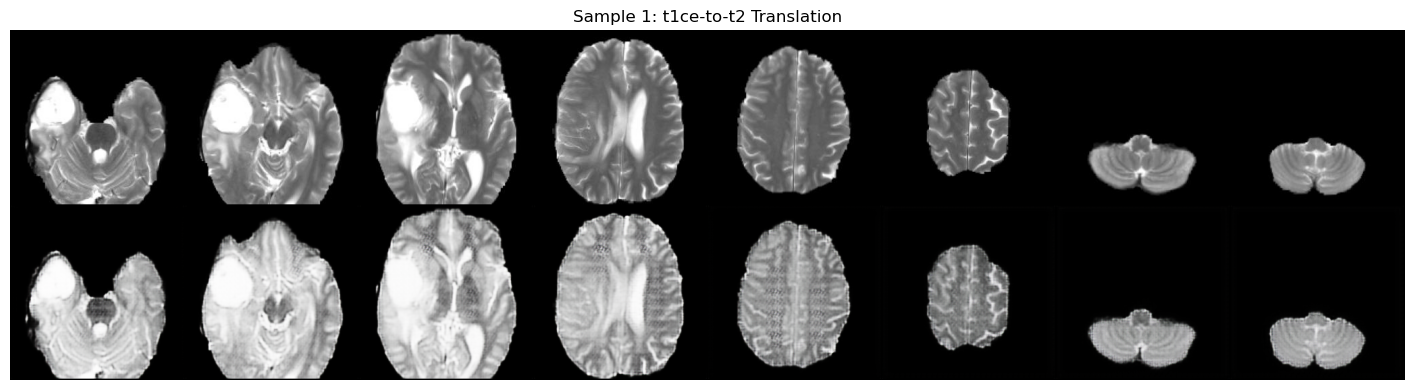

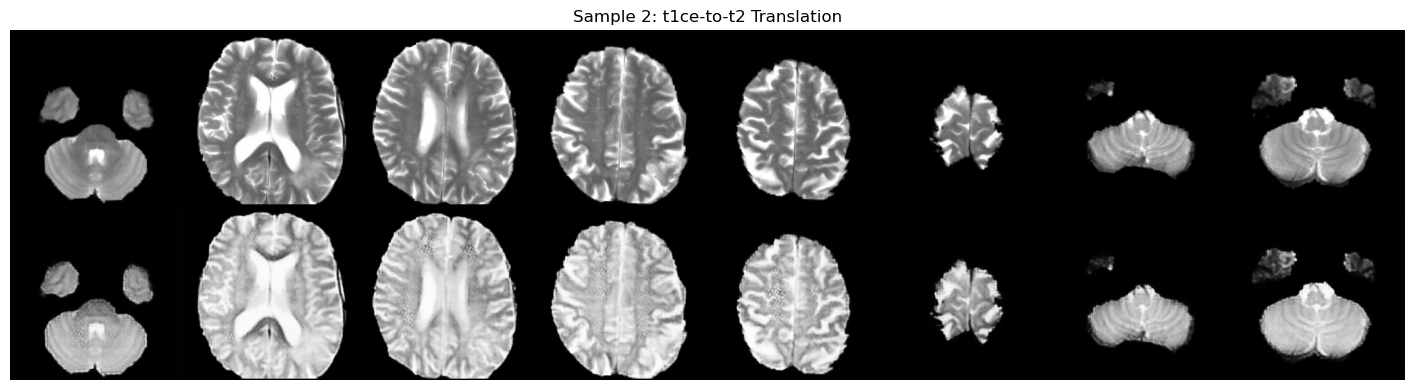

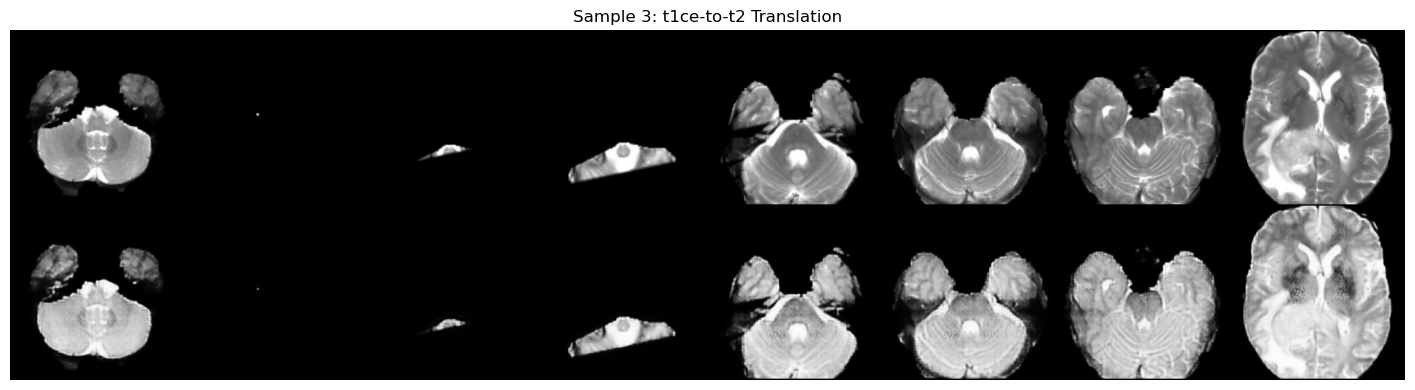

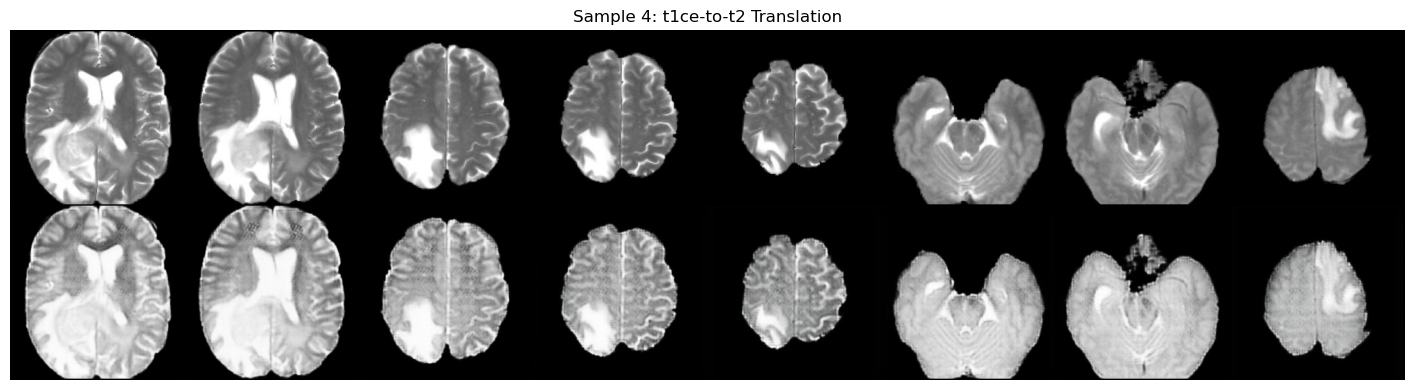

In [ ]:
_ = trainer.test(model, datamodule=datamodule)

make some prediction

In [ ]:
predictions = trainer.predict(model, datamodule=datamodule)

/Users/sanjohngiangino/miniconda3/envs/autosdf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

Images Generated: 831.


Save predicted Images

In [ ]:
os.makedirs("/Users/sanjohngiangino/Desktop/MultiConDos-main/predicted_images", exist_ok=True)

idx = 0
for tensor in predictions:
    for pred in tensor:
        save_image(
            pred.float().squeeze() * 0.5 + 0.5,
            fp=f"/Users/sanjohngiangino/Desktop/MultiConDos-main/predicted_images/{idx}.jpg",
        )
        idx += 1



Save Model Checkpoint

In [ ]:
trainer.save_checkpoint("/Users/sanjohngiangino/Desktop/MultiConDos-main/dsganckpt/" + 'dsganNEW.ckpt')


In [4]:
!pip install torch torchvision pytorch-lightning tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.3.0
    Uninstalling urllib3-2.3.0:
      Successfully uninstalled urllib3-2.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.2.0 requires fsspec[http]<=2024.9.0,>=2023.1.0, but you have fsspec 2024.12.0 which is incompatible.


In [5]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

Launching TensorBoard...

# 3. Fine Tuning For Mask

To generate the Mask in the paper they finetune the DSGAN

In [21]:
DATA_CONFIG_FINE = {
    "t1ce_dir": os.path.join("/Users/sanjohngiangino/Desktop/MultiConDos-main/DATA/t1ce_jpg", "*.jpg"),
    "mask_dir": os.path.join("/Users/sanjohngiangino/Desktop/MultiConDos-main/DATA/mask_jpg", "*.jpg"),
    "loader_config": {
    },
    "sample_size": 8,
    "batch_size": 8,
}

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        #inputs = torch.clamp(inputs, 0, 1)  

        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        
        # Clamping di pt per evitare underflow/overflow
        pt = torch.exp(-BCE_loss)
        pt = torch.clamp(pt, 1e-6, 1-1e-6)  # Clamp pt to avoid extreme values
        
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            smooth = 1e-6
            F_loss_sum = torch.sum(F_loss)
            #if F_loss_sum <= 0:
            #    F_loss_sum = smooth
            return torch.log(F_loss_sum + smooth)
        

class MultiChannelDiceLoss(nn.Module):
    def __init__(self, smooth=1e-6, apply_activation=True):
        super(MultiChannelDiceLoss, self).__init__()
        self.smooth = smooth
        self.apply_activation = apply_activation

    def forward(self, inputs, targets):
        assert inputs.size() == targets.size(), 'predict & target shape do not match'

        inputs = (inputs + 1) / 2
        targets = (targets + 1) / 2

        inputs = inputs.view(inputs.size(0), inputs.size(1), -1)
        targets = targets.view(targets.size(0), targets.size(1), -1)
        
        intersection = (inputs * targets).sum(dim=2)
        inputs_sum = inputs.sum(dim=2)
        targets_sum = targets.sum(dim=2)
        
        dice_coeff = (2 * intersection + self.smooth) / (inputs_sum + targets_sum + self.smooth)
        dice_loss = 1 - dice_coeff.mean()
        return dice_loss

In [23]:
class MultiConDos(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.share = DSGAN.load_from_checkpoint("/Users/sanjohngiangino/Desktop/MultiConDos-main/dsganckpt/dsganNEW.ckpt",**MODEL_CONFIG)
        self.loss_function = torch.nn.MSELoss()
        self.loss_focal = FocalLoss(alpha=0.75, gamma=2, logits=True, reduce=False)
        self.loss_dice = MultiChannelDiceLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
            
    def forward(self, x):
        return self.share(x)
    
    def training_step(self, batch, batch_idx):
        x = batch["t1ce"]
        y_true = batch["t2"]
        
        y_pred = self(x)
        loss_base = self.loss_focal(y_pred, y_true)

        loss_dice = self.loss_dice(y_pred, y_true)
        
        
        loss_mse = self.loss_function(y_pred, y_true)
        loss = loss_base +  loss_mse + loss_dice * 10


        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('focal loss', loss_base, on_step=True, on_epoch=True, prog_bar=True)
        self.log('loss mse', loss_mse, on_step=True, on_epoch=True, prog_bar=True)
        self.log('loss dice', loss_dice, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        self.display_results(batch, batch_idx, "validate")

    def predict_step(self, batch, batch_idx):
        return self(batch)
    
    def display_results(self, batch, batch_idx, stage):
        x = batch["t1ce"]
     
        fake_y = self(x)

        if stage == "validate":
            title = f"Epoch {self.current_epoch+1}: t1ce to mask"
        else:
            title = f"Segmentation {batch_idx+1}: t1ce to mask"

        visualize_result(
            torch.cat([x, fake_y], dim=0),
            nrow=len(x),
            title=title,
        )
    def get_lr_scheduler(self, optimizer):
        def lr_lambda(epoch):
            len_decay_phase = self.hparams.num_epochs - self.hparams.decay_epochs + 1.0
            curr_decay_step = max(0, epoch - self.hparams.decay_epochs + 1.0)
            val = 1.0 - curr_decay_step / len_decay_phase
            return max(0.0, val)

        return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    def configure_optimizers(self):
        opt_config = {
            "lr": self.hparams.lr,
            "betas": self.hparams.betas,
        }
        opt_gen = self.optimizer(
            list(self.t1ce_t2_gen.parameters()),
            **opt_config,
        )
        opt_disc = self.optimizer(
            list(self.t1ce_disc.parameters()) + list(self.t2_disc.parameters()),
            **opt_config,
        )
        optimizers = [opt_gen, opt_disc]
        schedulers = [self.get_lr_scheduler(opt) for opt in optimizers]
        return optimizers, schedulers
    
    def on_train_epoch_end(self):
        # update learning rates
        # print current state of epoch
        logged_values = self.trainer.progress_bar_metrics
        print(
            f"Epoch {self.current_epoch+1}",
            *[f"{k}: {v:.5f}" for k, v in logged_values.items()],
            sep=" - ",
        )
    
    def configure_optimizers(self):
        return self.optimizer

---

In [24]:
class MulticonDatamodule_fine(L.LightningDataModule):
    def __init__(
        self,
        t1ce_dir,
        mask_dir,
        loader_config,
        sample_size,
        batch_size,
    ):
        super().__init__()
        self.loader_config = loader_config
        self.sample_size = sample_size
        self.batch_size = batch_size

        # store file paths
        self.t1ce_filenames = sorted(glob.glob(t1ce_dir))
        self.t2_filenames = sorted(glob.glob(mask_dir))

        # define transformations for image augmentation
        self.transform = Augmentation()

    def setup(self, stage):
        if stage == "fit":
            self.train_t1ce = MulticonDataset(self.t1ce_filenames, self.transform, stage)
            self.train_t2 = MulticonDataset(self.t2_filenames, self.transform, stage)

        if stage in ["fit", "test", "predict"]:
            # to be used for test and prediction datasets as well
            self.valid_t1ce = MulticonDataset(self.t1ce_filenames, self.transform, None)
            self.valid_t2 = MulticonDataset(self.t2_filenames, self.transform, None)

    def train_dataloader(self):
        loader_config = {
            "shuffle": True,
            "drop_last": True,
            "batch_size": self.batch_size,
            **self.loader_config,
        }
        loader_t1ce = DataLoader(self.train_t1ce, **loader_config)
        loader_t2 = DataLoader(self.train_t2, **loader_config)
        loaders = {"t1ce": loader_t1ce, "t2": loader_t2}
        return CombinedLoader(loaders, mode="max_size_cycle")

    def val_dataloader(self):
        loader_t1ce = DataLoader(
            self.valid_t1ce,
            batch_size=self.sample_size,
            **self.loader_config,
        )
        loader_t2 = DataLoader(
            self.valid_t2,
            batch_size=self.sample_size,
            **self.loader_config,
        )
        loaders = {"t1ce": loader_t1ce, "t2": loader_t2}
        return CombinedLoader(loaders, mode="max_size_cycle") 

    def test_dataloader(self):
        return self.val_dataloader()

    def predict_dataloader(self):
        return DataLoader(
            self.valid_t2,
            batch_size=self.batch_size,
            **self.loader_config,
        )

In [ ]:
MODEL_CONFIG_FINE = {
    "hid_channels": 64,
    "optimizer": torch.optim.Adam,
    "lr": 2e-4,
    "betas": (0.5, 0.999),
    "lambda_idt": 0.5,
    "lambda_ds": (10, 10), 
    "buffer_size": 100,
    "num_epochs": 50,
    "decay_epochs": 8,
}

In [26]:
TRAIN_CONFIG_FINE = {
    "accelerator": "mps",
    "precision": 32,
    "devices": 1,
    "enable_checkpointing": True,
    "max_epochs": MODEL_CONFIG_FINE["num_epochs"],
    "limit_train_batches": 1.0,
    "limit_predict_batches": 1.0,
    "limit_val_batches": 1,
    "limit_test_batches": 5,
    "num_sanity_val_steps": 0,
    "check_val_every_n_epoch": 5,
}

In [27]:
model = MultiConDos()
datamodule_fine = MulticonDatamodule_fine(**DATA_CONFIG_FINE)
trainer = L.Trainer(**TRAIN_CONFIG_FINE)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..



  | Name          | Type                 | Params
-------------------------------------------------------
0 | share         | DSGAN                | 118 M 
1 | loss_function | MSELoss              | 0     
2 | loss_focal    | FocalLoss            | 0     
3 | loss_dice     | MultiChannelDiceLoss | 0     
-------------------------------------------------------
118 M     Trainable params
0         Non-trainable params
118 M     Total params
474.214   Total estimated model params size (MB)
/Users/sanjohngiangino/miniconda3/envs/autosdf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

/Users/sanjohngiangino/miniconda3/envs/autosdf/lib/python3.11/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch 1 - train_loss_step: 19.43201 - focal loss_step: 9.67997 - loss mse_step: 0.23804 - loss dice_step: 0.95140 - train_loss_epoch: 20.94113 - focal loss_epoch: 11.01548 - loss mse_epoch: 0.48990 - loss dice_epoch: 0.94358
Epoch 2 - train_loss_step: 19.25567 - focal loss_step: 9.67821 - loss mse_step: 0.28231 - loss dice_step: 0.92952 - train_loss_epoch: 19.30755 - focal loss_epoch: 9.60255 - loss mse_epoch: 0.25962 - loss dice_epoch: 0.94454
Epoch 3 - train_loss_step: 19.16993 - focal loss_step: 9.36962 - loss mse_step: 0.21607 - loss dice_step: 0.95842 - train_loss_epoch: 19.11803 - focal loss_epoch: 9.44264 - loss mse_epoch: 0.24394 - loss dice_epoch: 0.94315
Epoch 4 - train_loss_step: 19.14256 - focal loss_step: 9.41515 - loss mse_step: 0.21480 - loss dice_step: 0.95126 - train_loss_epoch: 19.14393 - focal loss_epoch: 9.49921 - loss mse_epoch: 0.24952 - loss dice_epoch: 0.93952


/Users/sanjohngiangino/miniconda3/envs/autosdf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]

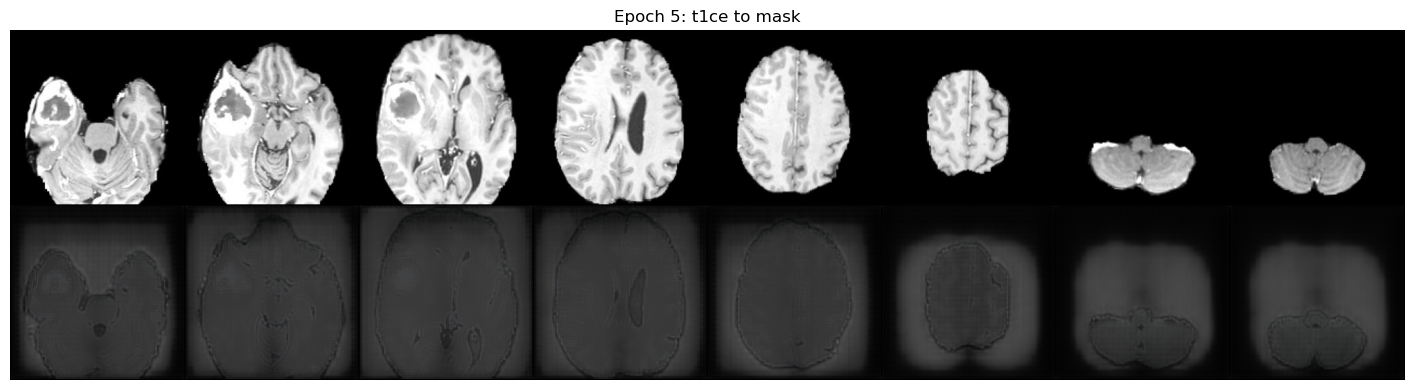

Epoch 5 - train_loss_step: 18.61061 - focal loss_step: 8.80102 - loss mse_step: 0.18585 - loss dice_step: 0.96237 - train_loss_epoch: 19.09786 - focal loss_epoch: 9.45865 - loss mse_epoch: 0.24921 - loss dice_epoch: 0.93900
Epoch 6 - train_loss_step: 18.81112 - focal loss_step: 8.85960 - loss mse_step: 0.18323 - loss dice_step: 0.97683 - train_loss_epoch: 19.26817 - focal loss_epoch: 9.58463 - loss mse_epoch: 0.21800 - loss dice_epoch: 0.94655
Epoch 7 - train_loss_step: 19.40310 - focal loss_step: 10.10117 - loss mse_step: 0.27068 - loss dice_step: 0.90312 - train_loss_epoch: 19.13008 - focal loss_epoch: 9.47838 - loss mse_epoch: 0.24741 - loss dice_epoch: 0.94043
Epoch 8 - train_loss_step: 19.20715 - focal loss_step: 9.64981 - loss mse_step: 0.18923 - loss dice_step: 0.93681 - train_loss_epoch: 19.09369 - focal loss_epoch: 9.44216 - loss mse_epoch: 0.24547 - loss dice_epoch: 0.94061
Epoch 9 - train_loss_step: 18.84895 - focal loss_step: 9.26671 - loss mse_step: 0.18656 - loss dice_ste

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10 - train_loss_step: 19.27595 - focal loss_step: 9.50793 - loss mse_step: 0.16677 - loss dice_step: 0.96013 - train_loss_epoch: 19.05355 - focal loss_epoch: 9.41667 - loss mse_epoch: 0.23338 - loss dice_epoch: 0.94035
Epoch 11 - train_loss_step: 19.08737 - focal loss_step: 9.38277 - loss mse_step: 0.26046 - loss dice_step: 0.94441 - train_loss_epoch: 19.16648 - focal loss_epoch: 9.51481 - loss mse_epoch: 0.21860 - loss dice_epoch: 0.94331
Epoch 12 - train_loss_step: 19.23571 - focal loss_step: 9.71747 - loss mse_step: 0.26046 - loss dice_step: 0.92578 - train_loss_epoch: 19.07380 - focal loss_epoch: 9.43709 - loss mse_epoch: 0.24554 - loss dice_epoch: 0.93912
Epoch 13 - train_loss_step: 19.01719 - focal loss_step: 9.05886 - loss mse_step: 0.23272 - loss dice_step: 0.97256 - train_loss_epoch: 19.03771 - focal loss_epoch: 9.40904 - loss mse_epoch: 0.24583 - loss dice_epoch: 0.93828
Epoch 14 - train_loss_step: 18.25998 - focal loss_step: 8.33658 - loss mse_step: 0.18776 - loss dice

Validation: |          | 0/? [00:00<?, ?it/s]

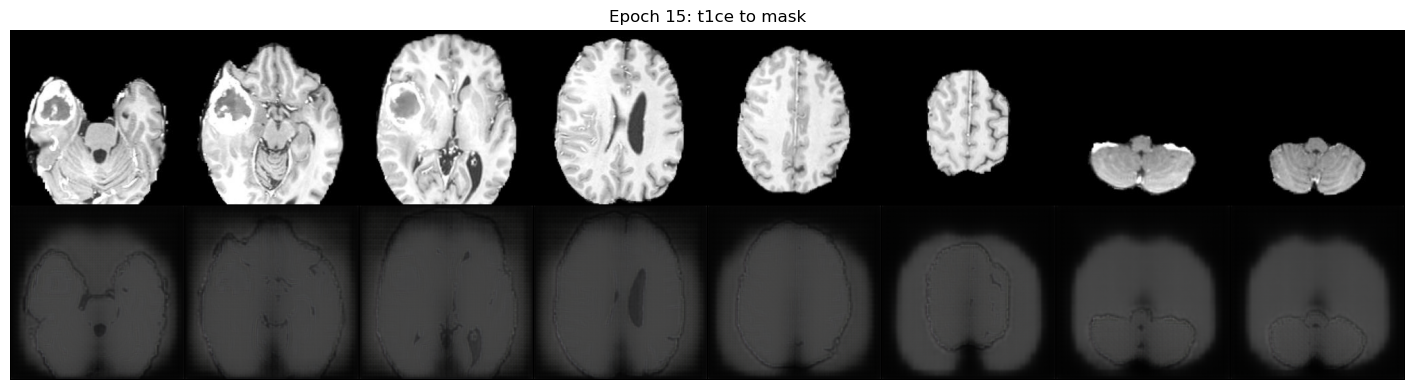

Epoch 15 - train_loss_step: 18.81662 - focal loss_step: 8.99759 - loss mse_step: 0.20013 - loss dice_step: 0.96189 - train_loss_epoch: 19.06966 - focal loss_epoch: 9.45948 - loss mse_epoch: 0.24495 - loss dice_epoch: 0.93652
Epoch 16 - train_loss_step: 18.90458 - focal loss_step: 9.19590 - loss mse_step: 0.21108 - loss dice_step: 0.94976 - train_loss_epoch: 19.02093 - focal loss_epoch: 9.41501 - loss mse_epoch: 0.24571 - loss dice_epoch: 0.93602
Epoch 17 - train_loss_step: 19.32321 - focal loss_step: 9.75877 - loss mse_step: 0.25071 - loss dice_step: 0.93137 - train_loss_epoch: 19.04616 - focal loss_epoch: 9.42948 - loss mse_epoch: 0.23117 - loss dice_epoch: 0.93855
Epoch 18 - train_loss_step: 19.02120 - focal loss_step: 9.24593 - loss mse_step: 0.23030 - loss dice_step: 0.95450 - train_loss_epoch: 19.08521 - focal loss_epoch: 9.48142 - loss mse_epoch: 0.24437 - loss dice_epoch: 0.93594
Epoch 19 - train_loss_step: 18.79049 - focal loss_step: 8.96932 - loss mse_step: 0.21882 - loss dice

Validation: |          | 0/? [00:00<?, ?it/s]

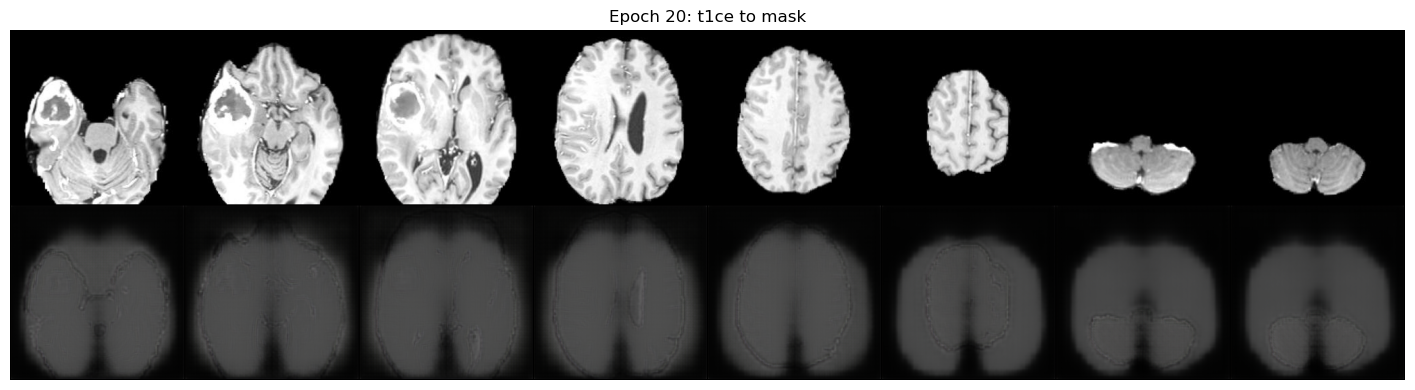

Epoch 20 - train_loss_step: 18.98170 - focal loss_step: 9.21929 - loss mse_step: 0.23604 - loss dice_step: 0.95264 - train_loss_epoch: 19.07337 - focal loss_epoch: 9.47887 - loss mse_epoch: 0.23494 - loss dice_epoch: 0.93596
Epoch 21 - train_loss_step: 19.33239 - focal loss_step: 9.95404 - loss mse_step: 0.27736 - loss dice_step: 0.91010 - train_loss_epoch: 19.03624 - focal loss_epoch: 9.44665 - loss mse_epoch: 0.24250 - loss dice_epoch: 0.93471
Epoch 22 - train_loss_step: 19.10106 - focal loss_step: 9.88588 - loss mse_step: 0.25889 - loss dice_step: 0.89563 - train_loss_epoch: 19.08183 - focal loss_epoch: 9.48284 - loss mse_epoch: 0.22883 - loss dice_epoch: 0.93702
Epoch 23 - train_loss_step: 19.10535 - focal loss_step: 9.51168 - loss mse_step: 0.22950 - loss dice_step: 0.93642 - train_loss_epoch: 19.01199 - focal loss_epoch: 9.40346 - loss mse_epoch: 0.21136 - loss dice_epoch: 0.93972
Epoch 24 - train_loss_step: 19.34457 - focal loss_step: 10.25136 - loss mse_step: 0.27863 - loss dic

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25 - train_loss_step: 19.10318 - focal loss_step: 9.45577 - loss mse_step: 0.22135 - loss dice_step: 0.94261 - train_loss_epoch: 19.03068 - focal loss_epoch: 9.43369 - loss mse_epoch: 0.24019 - loss dice_epoch: 0.93568
Epoch 26 - train_loss_step: 19.40969 - focal loss_step: 10.45524 - loss mse_step: 0.32269 - loss dice_step: 0.86318 - train_loss_epoch: 19.05490 - focal loss_epoch: 9.46560 - loss mse_epoch: 0.23724 - loss dice_epoch: 0.93521
Epoch 27 - train_loss_step: 19.57560 - focal loss_step: 10.33771 - loss mse_step: 0.30681 - loss dice_step: 0.89311 - train_loss_epoch: 19.07451 - focal loss_epoch: 9.49386 - loss mse_epoch: 0.24335 - loss dice_epoch: 0.93373
Epoch 28 - train_loss_step: 19.06868 - focal loss_step: 9.26812 - loss mse_step: 0.14605 - loss dice_step: 0.96545 - train_loss_epoch: 18.98346 - focal loss_epoch: 9.37644 - loss mse_epoch: 0.21493 - loss dice_epoch: 0.93921
Epoch 29 - train_loss_step: 19.45300 - focal loss_step: 10.16722 - loss mse_step: 0.28926 - loss d

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30 - train_loss_step: 19.21797 - focal loss_step: 9.78200 - loss mse_step: 0.25562 - loss dice_step: 0.91803 - train_loss_epoch: 19.05653 - focal loss_epoch: 9.46066 - loss mse_epoch: 0.24218 - loss dice_epoch: 0.93537
Epoch 31 - train_loss_step: 17.62529 - focal loss_step: 7.57705 - loss mse_step: 0.18690 - loss dice_step: 0.98613 - train_loss_epoch: 18.99127 - focal loss_epoch: 9.41694 - loss mse_epoch: 0.22776 - loss dice_epoch: 0.93466
Epoch 32 - train_loss_step: 19.47300 - focal loss_step: 10.52469 - loss mse_step: 0.32972 - loss dice_step: 0.86186 - train_loss_epoch: 19.01144 - focal loss_epoch: 9.43526 - loss mse_epoch: 0.22678 - loss dice_epoch: 0.93494
Epoch 33 - train_loss_step: 18.97322 - focal loss_step: 9.08687 - loss mse_step: 0.20920 - loss dice_step: 0.96771 - train_loss_epoch: 19.03174 - focal loss_epoch: 9.46328 - loss mse_epoch: 0.23787 - loss dice_epoch: 0.93306
Epoch 34 - train_loss_step: 19.16300 - focal loss_step: 9.48958 - loss mse_step: 0.21128 - loss dic

Validation: |          | 0/? [00:00<?, ?it/s]

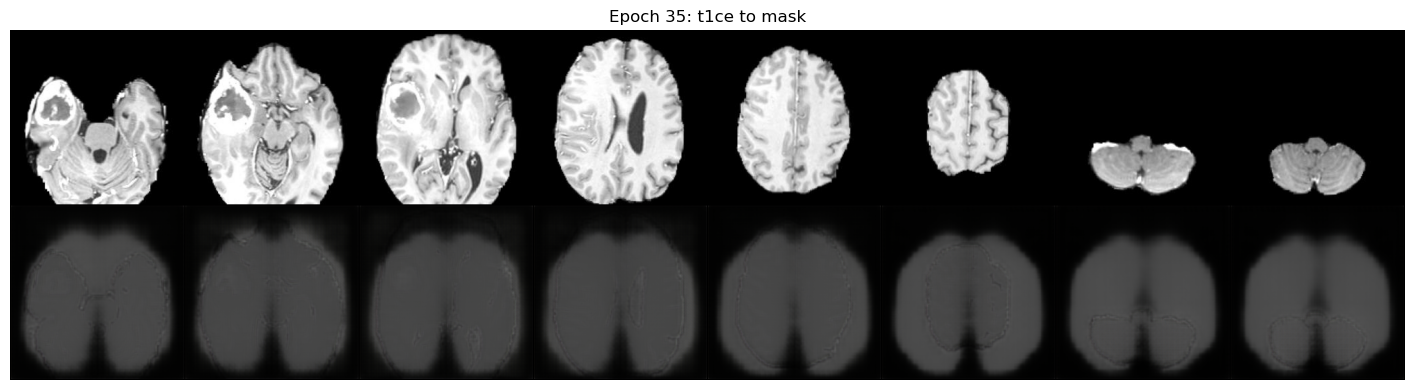

Epoch 35 - train_loss_step: 18.98774 - focal loss_step: 9.14724 - loss mse_step: 0.21469 - loss dice_step: 0.96258 - train_loss_epoch: 19.05043 - focal loss_epoch: 9.47233 - loss mse_epoch: 0.23326 - loss dice_epoch: 0.93448
Epoch 36 - train_loss_step: 19.10583 - focal loss_step: 9.63498 - loss mse_step: 0.24091 - loss dice_step: 0.92299 - train_loss_epoch: 19.04358 - focal loss_epoch: 9.46780 - loss mse_epoch: 0.22351 - loss dice_epoch: 0.93523
Epoch 37 - train_loss_step: 18.89178 - focal loss_step: 9.07081 - loss mse_step: 0.21263 - loss dice_step: 0.96083 - train_loss_epoch: 18.99853 - focal loss_epoch: 9.43475 - loss mse_epoch: 0.23783 - loss dice_epoch: 0.93259
Epoch 38 - train_loss_step: 18.62451 - focal loss_step: 8.64108 - loss mse_step: 0.20538 - loss dice_step: 0.97781 - train_loss_epoch: 19.06046 - focal loss_epoch: 9.49295 - loss mse_epoch: 0.24145 - loss dice_epoch: 0.93261
Epoch 39 - train_loss_step: 18.83959 - focal loss_step: 9.06564 - loss mse_step: 0.20129 - loss dice

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40 - train_loss_step: 19.18157 - focal loss_step: 9.66326 - loss mse_step: 0.25385 - loss dice_step: 0.92645 - train_loss_epoch: 19.04219 - focal loss_epoch: 9.47718 - loss mse_epoch: 0.23867 - loss dice_epoch: 0.93263
Epoch 41 - train_loss_step: 18.99385 - focal loss_step: 9.29389 - loss mse_step: 0.21755 - loss dice_step: 0.94824 - train_loss_epoch: 19.02274 - focal loss_epoch: 9.46096 - loss mse_epoch: 0.21717 - loss dice_epoch: 0.93446
Epoch 42 - train_loss_step: 19.44023 - focal loss_step: 10.05098 - loss mse_step: 0.27092 - loss dice_step: 0.91183 - train_loss_epoch: 19.00889 - focal loss_epoch: 9.44938 - loss mse_epoch: 0.23401 - loss dice_epoch: 0.93255
Epoch 43 - train_loss_step: 18.71943 - focal loss_step: 8.88750 - loss mse_step: 0.20334 - loss dice_step: 0.96286 - train_loss_epoch: 19.03990 - focal loss_epoch: 9.49365 - loss mse_epoch: 0.23740 - loss dice_epoch: 0.93088
Epoch 44 - train_loss_step: 19.14472 - focal loss_step: 9.35126 - loss mse_step: 0.21808 - loss dic

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45 - train_loss_step: 19.59925 - focal loss_step: 10.40792 - loss mse_step: 0.25099 - loss dice_step: 0.89403 - train_loss_epoch: 18.98413 - focal loss_epoch: 9.40728 - loss mse_epoch: 0.20700 - loss dice_epoch: 0.93698
Epoch 46 - train_loss_step: 19.35289 - focal loss_step: 9.73763 - loss mse_step: 0.25179 - loss dice_step: 0.93635 - train_loss_epoch: 19.10506 - focal loss_epoch: 9.53391 - loss mse_epoch: 0.21734 - loss dice_epoch: 0.93538
Epoch 47 - train_loss_step: 18.49048 - focal loss_step: 8.65050 - loss mse_step: 0.20115 - loss dice_step: 0.96388 - train_loss_epoch: 19.01035 - focal loss_epoch: 9.44978 - loss mse_epoch: 0.22382 - loss dice_epoch: 0.93367
Epoch 48 - train_loss_step: 17.20760 - focal loss_step: 7.11547 - loss mse_step: 0.17667 - loss dice_step: 0.99155 - train_loss_epoch: 19.00729 - focal loss_epoch: 9.44816 - loss mse_epoch: 0.22512 - loss dice_epoch: 0.93340
Epoch 49 - train_loss_step: 19.32346 - focal loss_step: 10.01588 - loss mse_step: 0.25885 - loss di

Validation: |          | 0/? [00:00<?, ?it/s]

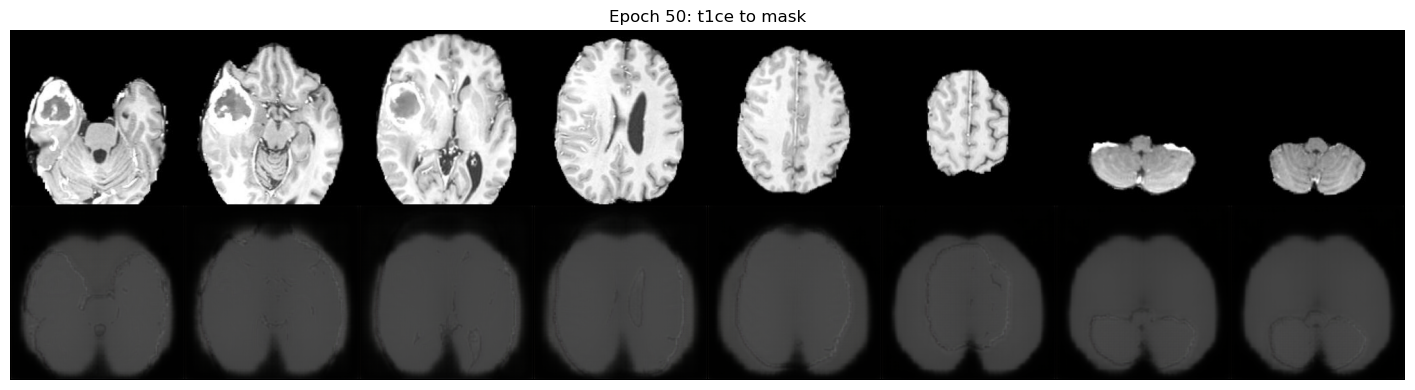

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50 - train_loss_step: 19.40335 - focal loss_step: 10.21721 - loss mse_step: 0.29052 - loss dice_step: 0.88956 - train_loss_epoch: 18.99431 - focal loss_epoch: 9.44165 - loss mse_epoch: 0.23183 - loss dice_epoch: 0.93208


In [28]:

trainer.fit(model, datamodule=datamodule_fine)

In [29]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

prediction of the finetuning

In [30]:
trainer.save_checkpoint("/Users/sanjohngiangino/Desktop/MultiConDos-main/finetune_ckpt/" + 'FINETUNEFINAL.ckpt')


In [31]:
predictions = trainer.predict(model, datamodule=datamodule_fine)

/Users/sanjohngiangino/miniconda3/envs/autosdf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

### Saving the generated images.

In [32]:
os.makedirs("/Users/sanjohngiangino/Desktop/MultiConDos-main/mask_generated", exist_ok=True)

idx = 0
for tensor in predictions:
    for pred in tensor:
        save_image(
            pred.float().squeeze() * 0.5 + 0.5,
            fp=f"/Users/sanjohngiangino/Desktop/MultiConDos-main/mask_generated/{idx}.jpg",
        )
        idx += 1


 ---